# Toy Example notebook

Notebook to replicate the results of the section "Toy example"

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy
import time
import sys
import pickle


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pyro.set_rng_seed(0)

In [2]:
plt.rcParams['figure.dpi'] = 100

# Data generation

In [3]:
def generate_data(seed):

    pyro.set_rng_seed(seed)

    N1 = 300
    N2 = 201

    std_noise = 0.2
    X1 = torch.linspace(0.0, 3., N1)
    X2 = torch.linspace(3.0, 5., N2)

    A = torch.linspace(0.5, 2., N1)
    y1 = A * torch.sin(4.* X1) + dist.Normal(0.0, std_noise).sample(sample_shape=(N1,))
    y2 = 2 * torch.sin(8.* X2) + dist.Normal(0.0, std_noise).sample(sample_shape=(N2,))

    X = torch.concat((X1,X2))
    y = torch.concat((y1,y2))

    # Data for initial learning
    T = 100
    X_init = X[:T]
    y_init = y[:T]

    # Data for on-line update
    X_t = X[T:]
    y_t = y[T:]

    return X_init, y_init, X_t, y_t

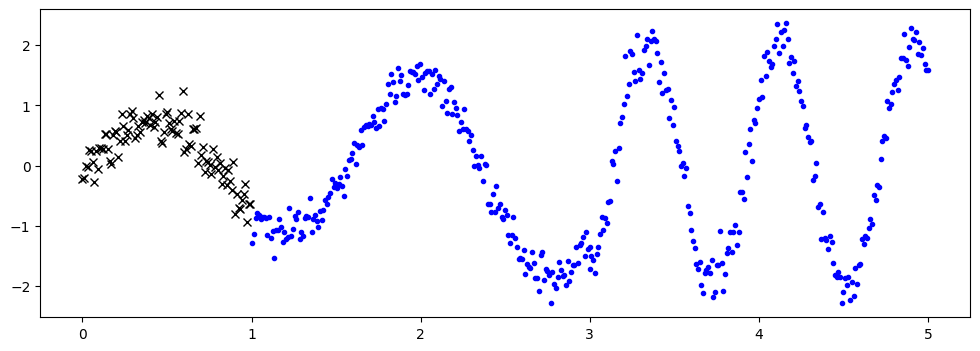

In [4]:
fig = plt.figure(figsize=(12,4))

X_init, y_init, X_t, y_t = generate_data(0)
X_plot = torch.cat((X_init,X_t))
y_plot = torch.cat((y_init,y_t))
plt.plot(X_init.numpy(), y_init.numpy(), "xk")
plt.plot(X_t.numpy(), y_t.numpy(), ".b")

fig.savefig('Toy_data.png')

# General configuration

In [5]:
# For the paper experiments
#N_iter = 1000 # Number of iterations, for each iteration a different dataset (seed) is generated

# For debugging
N_iter = 2 # Number of iterations, for each iteration a different dataset (seed) is generated

M = 10
T = 100

# Optimization parameters
num_steps_init = 200
num_steps_online = 1

lamb_ = 0.98

# ADAPTIVE MODELS

In [6]:
parentdir = "../lib/"
sys.path.insert(0, parentdir) 

from AdaptiveLearningUtilities import model_update_AGP, model_update_FastAGP
from AdaptiveSparseGPRegression import AdaptiveSparseGPRegression 

## Fast-AGP: Adaptive SVGP without inference

Model parameters are NOT updated (only inducing points)

In [7]:
print('Fast-AGP: Adaptive SVGP without inference')

Fast-AGP: Adaptive SVGP without inference


In [8]:
mse_pred_iter = []
mean_pred_iter = []
std_pred_iter = []
IC_95_iter = []
train_time_iter = []
test_time_iter =[]

for seed in range(N_iter):
  print(seed)
  X_init, y_init, X_t, y_t = generate_data(seed)
  # initialize the kernel and model
  pyro.clear_param_store()
  kernel = gp.kernels.RBF(input_dim=1)

  # initialize the inducing inputs in interval [0,1] 
  M = 10
  inducing_points = torch.linspace(0, 1, M)
  Xu = torch.Tensor(copy.copy(inducing_points))

  # Define the model
  osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-4)

  # the way we setup inference is similar to above
  optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
  loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  # Initialize the model running a complete inference of all the parameters
  for i in range(num_steps_init):
      optimizer.zero_grad()
      loss = loss_fn(osgpr.model, osgpr.guide)
      loss.backward()
      optimizer.step()

  # We update the model with the last inferred parameters to later online learning
  osgpr.update_all_variables()

  mse_pred = []
  mean_pred = []
  std_pred = []
  IC_95 = []
  test_time = 0
  train_time = 0

  for t, (x, y) in enumerate(zip(X_t, y_t)):
    
      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = osgpr(X_new, noiseless=False)
      test_time += (time.process_time()-start) 
      
      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())
      
      std = torch.sqrt(cov)
      std_pred.append(std.numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
      # Update model
      start = time.process_time()
      loss = model_update_FastAGP(osgpr, X_new, y_new)
      train_time += (time.process_time()-start) 
  
  # Save variables
  mse_pred_iter.append(mse_pred)
  std_pred_iter.append(std_pred)
  mean_pred_iter.append(mean_pred)
  IC_95_iter.append(IC_95)
  train_time_iter.append(train_time)
  test_time_iter.append(test_time)
    
    
data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

with open('../results/Toy_Fast-AGP.pickle', 'wb') as handle:
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

0
1


## AGP: Adaptive SVGP with inference

We apply inference over all model parameters

In [9]:
print('AGP: Adaptive SVGP with inference')

AGP: Adaptive SVGP with inference


In [10]:
mse_pred_iter = []
std_pred_iter = []
mean_pred_iter = []
IC_95_iter = []
train_time_iter = []
test_time_iter =[]

for seed in range(N_iter):
  print(seed)
  X_init, y_init, X_t, y_t = generate_data(seed)
  # initialize the kernel and model
  pyro.clear_param_store()
  kernel = gp.kernels.RBF(input_dim=1)

  # initialize the inducing inputs in interval [0,1] 
  M = 10
  inducing_points = torch.linspace(0, 1, M)
  Xu = torch.Tensor(copy.copy(inducing_points))

  # Define the model
  osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-3)

  # the way we setup inference is similar to above
  optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
  loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  # Initialize the model running a complete inference of all the parameters
  for i in range(num_steps_init):
      optimizer.zero_grad()
      loss = loss_fn(osgpr.model, osgpr.guide)
      loss.backward()
      optimizer.step()

  # We update the model with the last inferred parameters to later online learning
  osgpr.update_all_variables()

  mse_pred = []
  std_pred = []
  mean_pred = []
  IC_95 = []
  test_time = 0
  train_time = 0

  for t, (x, y) in enumerate(zip(X_t, y_t)):
    
      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = osgpr(X_new, noiseless=False)
      test_time += (time.process_time()-start) 
      
      mean_pred.append(pred.numpy())
      
      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())
      
      std = torch.sqrt(cov)
      std_pred.append(std.numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
      # Update model
      start = time.process_time()
      loss = model_update_AGP(osgpr, X_new, y_new, optimizer = optimizer, num_steps = num_steps_online)
      train_time += (time.process_time()-start) 
  
  # Save variables
  mse_pred_iter.append(mse_pred)
  mean_pred_iter.append(mean_pred)
  std_pred_iter.append(std_pred)
  IC_95_iter.append(IC_95)
  train_time_iter.append(train_time)
  test_time_iter.append(test_time)
    
data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

with open('../results/Toy_AGP.pickle', 'wb') as handle:
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

0
1


## Adaptive VSGP with VSI

In [11]:
print('AGP-VSI: Adaptive VSGP with VSI')

AGP-VSI: Adaptive VSGP with VSI


In [12]:
from AdaptiveELBO import adaptive_elbo

In [13]:
mse_pred_iter = []
mean_pred_iter = []
std_pred_iter = []
IC_95_iter = []
train_time_iter = []
test_time_iter =[]

for seed in range(N_iter):
  print(seed)
  X_init, y_init, X_t, y_t = generate_data(seed)

  # initialize the inducing inputs in interval [0,1] 
  inducing_points = torch.linspace(0, 1, M)
  Xu = torch.Tensor(copy.copy(inducing_points))

  # initialize the kernel and model
  pyro.clear_param_store()
  kernel = gp.kernels.RBF(input_dim=1)

  likelihood = gp.likelihoods.Gaussian()

  forget_factor =  torch.flip(torch.cumprod(lamb_*torch.ones_like(y_init), dim=0), [0])
  forget_factor = torch.cat((forget_factor[1:],torch.tensor([1.0])))

  # turn on "whiten" flag for more stable optimization
  vsgp = gp.models.VariationalSparseGP(
      X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
  )

  optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.05)
  loss_fn = adaptive_elbo

  for i in range(num_steps_init):
      optimizer.zero_grad()
      loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
      loss.backward()
      optimizer.step()

  mse_pred = []
  mean_pred = []
  std_pred = []
  IC_95 = []
  test_time = 0
  train_time = 0


  X_window = X_init
  y_window = y_init 

  for t, (x, y) in enumerate(zip(X_t, y_t)):
    
      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = vsgp(X_new)
      test_time += (time.process_time()-start) 
      
      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())
      
      cov = cov + vsgp.likelihood.variance
      std = torch.sqrt(cov)
      std_pred.append(std.detach().numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

      start = time.process_time()
      # Update model with new data
      X_window = torch.cat((X_window[1:], X_new))
      y_window = torch.cat((y_window[1:], y_new))

      forget_factor = torch.cat((lamb_*forget_factor[1:],torch.tensor([1.0]))) 

      vsgp.set_data(X_window, y_window)

      for i in range(50*num_steps_online):
          optimizer.zero_grad()
          loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
          loss.backward()
          optimizer.step()
      train_time += (time.process_time()-start) 

  
  # Save variables
  mse_pred_iter.append(mse_pred)
  std_pred_iter.append(std_pred)
  mean_pred_iter.append(mean_pred)
  IC_95_iter.append(IC_95)
  train_time_iter.append(train_time)
  test_time_iter.append(test_time)
    
    

data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

with open('../results/Toy_AGP-VSI.pickle', 'wb') as handle:
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


0
1


# BASELINES

## Training a GP per iteration with a sliding data window

In [14]:
print('w-SVGP: A windowed SVGP')

w-SVGP: A windowed SVGP


In [15]:
mse_pred_iter = []
mean_pred_iter = []
std_pred_iter = []
IC_95_iter = []
train_time_iter = []
test_time_iter =[]

for seed in range(N_iter):
  print(seed)
  X_init, y_init, X_t, y_t = generate_data(seed)

  # initialize the inducing inputs in interval [0,1] 
  inducing_points = torch.linspace(0, 1, M)
  Xu = torch.Tensor(copy.copy(inducing_points))

  # initialize the kernel, likelihood, and model
  pyro.clear_param_store()
  kernel = gp.kernels.RBF(input_dim=1)
  likelihood = gp.likelihoods.Gaussian()
  # turn on "whiten" flag for more stable optimization
  vsgp = gp.models.VariationalSparseGP(
      X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
  )

  # Train the first model
  optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.005)
  loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  for i in range(num_steps_init):
      optimizer.zero_grad()
      loss = loss_fn(vsgp.model, vsgp.guide)
      loss.backward()
      optimizer.step()

  mse_pred = []
  mean_pred = []
  std_pred = []
  IC_95 = []
  test_time = 0
  train_time = 0


  X_window = X_init
  y_window = y_init 

  for t, (x, y) in enumerate(zip(X_t, y_t)):
    
      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = vsgp(X_new)
      test_time += (time.process_time()-start) 
      
      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())
      
      cov = cov + vsgp.likelihood.variance
      std = torch.sqrt(cov)
      std_pred.append(std.detach().numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

      start = time.process_time()
      # Update model with new data
      X_window = torch.cat((X_window[1:], X_new))
      y_window = torch.cat((y_window[1:], y_new))

      vsgp.set_data(X_window, y_window)

      for i in range(50*num_steps_online):
          optimizer.zero_grad()
          loss = loss_fn(vsgp.model, vsgp.guide)
          loss.backward()
          optimizer.step()
      train_time += (time.process_time()-start) 

  
  # Save variables
  mse_pred_iter.append(mse_pred)
  std_pred_iter.append(std_pred)
  mean_pred_iter.append(mean_pred)
  IC_95_iter.append(IC_95)
  train_time_iter.append(train_time)
  test_time_iter.append(test_time)

data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

with open('../results/Toy_w-SVGP.pickle', 'wb') as handle:
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

0
1


## Online SGP

This is the model proposed in:

https://arxiv.org/pdf/1705.07131.pdf

https://github.com/thangbui/streaming_sparse_gp/blob/b46e6e4a9257937f7ca26ac06099f5365c8b50d8/code/osgpr.py

But here, we used the pythorch iomplementation included in

https://github.com/wjmaddox/online_gp



In [16]:
import sys
sys.path.append('../experiments/regression/')

from copy import deepcopy

import math

import gpytorch
from gpytorch import mlls
from online_gp import models


In [17]:
print('OSGP: Online SGP ')

OSGP: Online SGP 


In [18]:
mse_pred_iter = []
mean_pred_iter = []
std_pred_iter = []
IC_95_iter = []
train_time_iter = []
test_time_iter =[]

for seed in range(N_iter+10):
  print(seed)
  try:
    # Some iterations generate convergence problems, so we remove them
    X_init, y_init, X_t, y_t = generate_data(seed)
  
    init_x= X_init[:,None]
    init_y= y_init[:,None]
    X = X_t[:,None]
    Y = y_t[:,None]

    # Initialize the model
    covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    inducing_points = torch.linspace(0,1, M)

    osgpr_model = models.StreamingSGPR(inducing_points, learn_inducing_locations=True, 
                                      covar_module=covar_module, num_data=init_x.size(0), jitter=1e-3)
    
    # Training a initial GP as starting point

    elbo = mlls.VariationalELBO(osgpr_model.likelihood, osgpr_model, num_data=init_x.size(0))
    mll = mlls.ExactMarginalLogLikelihood(osgpr_model.likelihood, osgpr_model)
    trainable_params = [
        dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
        dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
        dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
        dict(params=osgpr_model.variational_strategy._variational_distribution.parameters(), lr=1e-2)
    ]
    optimizer = torch.optim.Adam(trainable_params)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 400, 1e-4)

    osgpr_model.train()
    records = []
    for i in range(num_steps_init):
        optimizer.zero_grad()
        train_dist = osgpr_model(init_x)
        loss = -elbo(train_dist, init_y.squeeze(-1)).sum()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    osgpr_model.eval()
    osgpr_model = osgpr_model.get_fantasy_model(init_x, init_y, resample_ratio=0)

    mse_pred = []
    mean_pred = []
    std_pred = []
    IC_95 = []
    test_time = 0
    train_time = 0

    chunk_size = 100

    for t, (x, y) in enumerate(zip(X, Y)):
      
        X_new =  X[t:t+1]
        y_new = Y[t:t+1]

        # Compute test error predicting next sample
        start = time.process_time()  
        with torch.no_grad():
          pred, cov = osgpr_model.predict(X_new)
        test_time += (time.process_time()-start) 

        mean_pred.append(pred.numpy())
        
        mse = (pred-y_new)**2
        mse_pred.append(mse.numpy())

        std = torch.sqrt(cov)
        std_pred.append(std.detach().numpy())
        IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
        
        start = time.process_time()
        elbo = models.StreamingSGPRBound(osgpr_model)
        trainable_params = [
            dict(params=osgpr_model.likelihood.parameters(), lr=1e-2),
            dict(params=osgpr_model.covar_module.parameters(), lr=1e-2),
            dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-3),
        ]
        optimizer = torch.optim.Adam(trainable_params)
        for _ in range(1):
            optimizer.zero_grad()
            loss = -elbo(x.view(-1, 1), y.view(-1, 1))
            loss.backward()
            optimizer.step()
            
        resample_ratio = 0.1 if t % 2 == 1 else 0
        osgpr_model = osgpr_model.get_fantasy_model(x.view(-1, 1), y.view(-1, 1), resample_ratio)
        train_time += (time.process_time()-start) 
    # Save variables
    mse_pred_iter.append(mse_pred)
    std_pred_iter.append(std_pred)
    mean_pred_iter.append(mean_pred)
    IC_95_iter.append(IC_95)
    train_time_iter.append(train_time)
    test_time_iter.append(test_time)
  except:
    print('Error in seed: ')
    print(seed)

data = {'mse':mse_pred_iter,
    'std':std_pred_iter,
    'mean':mean_pred_iter,
    'IC_95':IC_95_iter,
    'train_time':train_time_iter,
    'test_time':test_time_iter}

with open('../results/Toy_OSGP.pickle', 'wb') as handle:
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

0


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


1
2


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


3
4
5
6
7
8
9
10
11


## Kernel Interpolation for Scalable Online Gaussian Processes (WISKI)

This is the WISKI (Woodbury Inversion with SKI) model from the paper:

Kernel Interpolation for Scalable Online Gaussian Processes

by Samuel Stanton, Wesley J. Maddox, Ian Delbridge, Andrew Gordon Wilson


The code is avaliable from https://github.com/wjmaddox/online_gp

In [19]:
from online_gp.models.stems import Identity
from online_gp import models
import gpytorch

In [20]:
print('WISKI: Kernel Interpolation for Scalable Online GP')

WISKI: Kernel Interpolation for Scalable Online GP


In [21]:
mse_pred_iter = []
mean_pred_iter = []
std_pred_iter = []
IC_95_iter = []
train_time_iter = []
test_time_iter =[]

#online_lr = 1e-1

for seed in range(N_iter):
  print(seed)
  
  X_init, y_init, X_t, y_t = generate_data(seed)
  init_x= X_init[:,None]
  init_y= y_init[:,None]
  X = X_t[:,None]
  Y = y_t[:,None]

  # Initialize the model

  stem = Identity(input_dim=X.size(-1))  

  covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

  wiski_model = models.OnlineSKIRegression(stem, init_x, init_y, lr=1e-1, grid_size=8*M, grid_bound=5.5, covar_module=covar_module)
  wiski_model.fit(init_x, init_y, num_steps_init)  # pretrain model

  mse_pred = []
  mean_pred = []
  std_pred = []
  IC_95 = []
  test_time = 0
  train_time = 0

  wiski_model.set_lr(1e-2)

  for t, (x, y) in enumerate(zip(X, Y)):
    
      X_new =  X[t:t+1]
      y_new = Y[t:t+1]

      # Compute test error predicting next sample
      start = time.process_time()  
      with torch.no_grad():
        pred, cov = wiski_model.predict(X_new)
      test_time += (time.process_time()-start) 

      mean_pred.append(pred.numpy())
    
      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())

      std = torch.sqrt(cov)
      std_pred.append(std.detach().numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
      
      start = time.process_time() 
      wiski_model.update(x, y)
      train_time += (time.process_time()-start) 
  
  # Save variables
  mse_pred_iter.append(mse_pred)
  std_pred_iter.append(std_pred)
  mean_pred_iter.append(mean_pred)
  IC_95_iter.append(IC_95)
  train_time_iter.append(train_time)
  test_time_iter.append(test_time)
    
data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

with open('../results/Toy_WISKI.pickle', 'wb') as handle:
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

0


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


1


## AGP for different $\lambda$ values

We apply inference over all model parameters

In [24]:
for value in [0, 0.25,0.5,0.75, 1, 2, 3]:
    lamb_ = np.exp(np.log(10**(-value))/T) 
    print(lamb_)
    
    mse_pred_iter = []
    std_pred_iter = []
    mean_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]

    for seed in range(N_iter):
      print(seed)
      try:
          X_init, y_init, X_t, y_t = generate_data(seed)
          # initialize the kernel and model
          pyro.clear_param_store()
          kernel = gp.kernels.RBF(input_dim=1)

          # initialize the inducing inputs in interval [0,1] 
          M = 10
          inducing_points = torch.linspace(0, 1, M)
          Xu = torch.Tensor(copy.copy(inducing_points))

          # Define the model
          osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-3)

          # the way we setup inference is similar to above
          optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
          loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

          # Initialize the model running a complete inference of all the parameters
          for i in range(num_steps_init):
              optimizer.zero_grad()
              loss = loss_fn(osgpr.model, osgpr.guide)
              loss.backward()
              optimizer.step()

          # We update the model with the last inferred parameters to later online learning
          osgpr.update_all_variables()

          mse_pred = []
          std_pred = []
          mean_pred = []
          IC_95 = []
          test_time = 0
          train_time = 0

          for t, (x, y) in enumerate(zip(X_t, y_t)):

              X_new = X_t[t:t+1]
              y_new = y_t[t:t+1]

              start = time.process_time()
              # Compute test error predicting next sample
              with torch.no_grad():
                pred, cov = osgpr(X_new, noiseless=False)
              test_time += (time.process_time()-start) 

              mean_pred.append(pred.numpy())

              mse = (pred-y_new)**2
              mse_pred.append(mse.numpy())

              std = torch.sqrt(cov)
              std_pred.append(std.numpy())
              IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
              # Update model
              start = time.process_time()
              loss = model_update_AGP(osgpr, X_new, y_new, optimizer = optimizer, num_steps = num_steps_online)
              train_time += (time.process_time()-start) 

          # Save variables
          mse_pred_iter.append(mse_pred)
          mean_pred_iter.append(mean_pred)
          std_pred_iter.append(std_pred)
          IC_95_iter.append(IC_95)
          train_time_iter.append(train_time)
          test_time_iter.append(test_time)
      except:
          print('Convergence error for this seed')

    data = {'mse':mse_pred_iter,
            'std':std_pred_iter,
            'mean':mean_pred_iter,
            'IC_95':IC_95_iter,
            'train_time':train_time_iter,
            'test_time':test_time_iter}

    with open('../results/Toy_AGP_lamb_'+str(value)+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

1.0
0
1
0.9942600739529568
0
1
0.9885530946569389
0
1
0.9828788730000323
0
1
0.9772372209558108
0
1
0.954992586021436
0
1
0.933254300796991
0
1


# Plot results

In [25]:
import pickle
import matplotlib.pyplot as plt

In [26]:
with open('../results/Toy_Fast-AGP.pickle', 'rb') as handle:
    data_fast_AGP = pickle.load(handle)

with open('../results/Toy_AGP.pickle', 'rb') as handle:
    data_AGP = pickle.load(handle)

with open('../results/Toy_AGP-VSI.pickle', 'rb') as handle:
    data_AGP_VSI = pickle.load(handle)

with open('../results/Toy_w-SVGP.pickle', 'rb') as handle:
    data_w_SVGP = pickle.load(handle)

with open('../results/Toy_OSGP.pickle', 'rb') as handle:
    data_OSGP = pickle.load(handle)

with open('../results/Toy_WISKI.pickle', 'rb') as handle:
    data_WISKI = pickle.load(handle)

In [27]:
seed =0
pyro.set_rng_seed(seed)

N1 = 300
N2 = 201

std_noise = 0.2
X1 = torch.linspace(0.0, 3., N1)
X2 = torch.linspace(3.0, 5., N2)

A = torch.linspace(0.5, 2., N1)
y1 = A * torch.sin(4.* X1) #+ dist.Normal(0.0, std_noise).sample(sample_shape=(N1,))
y2 = 2 * torch.sin(8.* X2) #+ dist.Normal(0.0, std_noise).sample(sample_shape=(N2,))

X = torch.concat((X1,X2))
y = torch.concat((y1,y2))

# Data for initial learning
T = 100
X_init = X[:T]
y_init = y[:T]

# Data for on-line update
X_t = X[T:]
y_t = y[T:]

y1 = A * torch.sin(4.* X1) + dist.Normal(0.0, std_noise).sample(sample_shape=(N1,))
y2 = 2 * torch.sin(8.* X2) + dist.Normal(0.0, std_noise).sample(sample_shape=(N2,))
y = torch.concat((y1,y2))
y_t2 = y[T:]

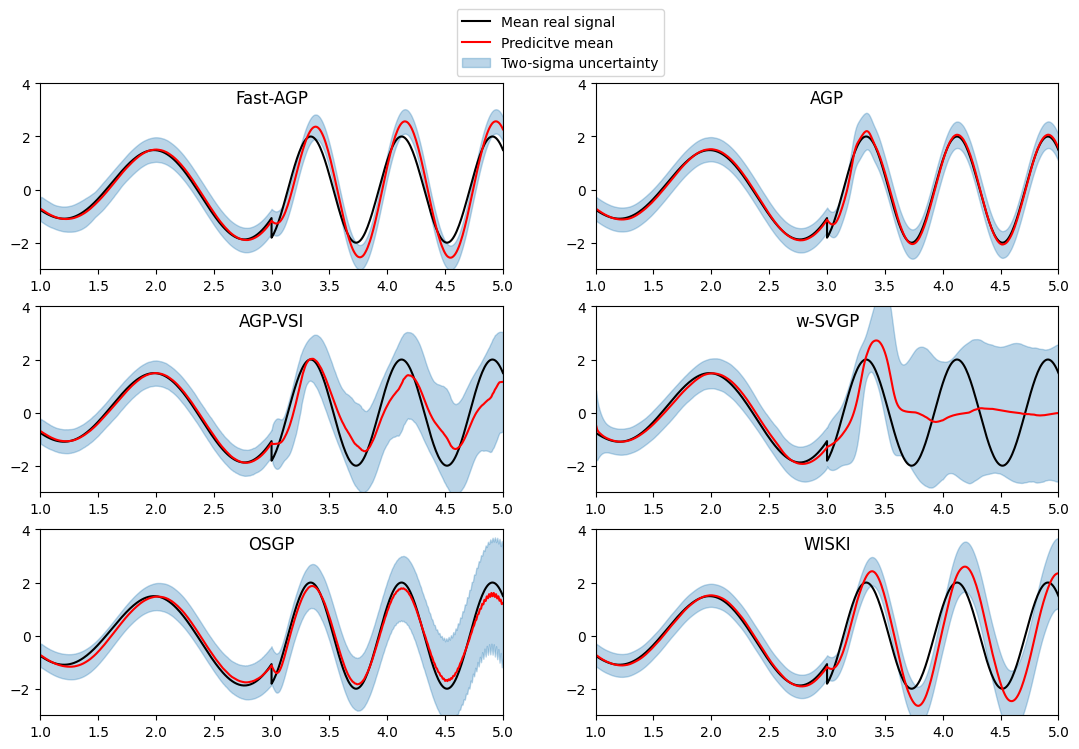

In [28]:
fig, axs = plt.subplots(figsize=(12, 8))

plt.tight_layout(pad=5.)

plt.subplot(3,2,1)

plt.plot(X_t.numpy(), y_t.numpy(),color="black", label='Mean real signal')
#plt.plot(X_t.numpy(), y_t2.numpy(),color="lightgray", marker=".", label='Data')

data = data_fast_AGP
mean = np.mean(np.squeeze(np.array(data['mean'])),0)
sd = np.mean(np.squeeze(np.array(data['std'])),0)

plt.plot(X_t, mean, color="red", label='Predicitve mean')
plt.fill_between(X_t, (mean - 2.0 * sd), (mean + 2.0 * sd), color="C0", alpha=0.3, label='Two-sigma uncertainty')
plt.legend(bbox_to_anchor=(0.9, 1.4), loc='upper left', borderaxespad=0.)
plt.xlim(1.,5.)
plt.ylim(-3.,4.)
plt.title('Fast-AGP',y=0.85)



plt.subplot(3,2,2)

plt.plot(X_t.numpy(), y_t.numpy(),color="black", label='Real signal')

data = data_AGP
mean = np.mean(np.squeeze(np.array(data['mean'])),0)
sd = np.mean(np.squeeze(np.array(data['std'])),0)

plt.plot(X_t, mean, color="red", label='Predicitve mean')
plt.fill_between(X_t, (mean - 2.0 * sd), (mean + 2.0 * sd), color="C0", alpha=0.3, label='Two-sigma uncertainty')
plt.xlim(1.,5.)
plt.ylim(-3.,4.)
plt.title('AGP',y=0.85)


plt.subplot(3,2,3)

plt.plot(X_t.numpy(), y_t.numpy(),color="black", label='Real signal')

data = data_AGP_VSI
mean = np.mean(np.squeeze(np.array(data['mean'])),0)
sd = np.mean(np.squeeze(np.array(data['std'])),0)

plt.plot(X_t, mean, color="red", label='Predicitve mean')
plt.fill_between(X_t, (mean - 2.0 * sd), (mean + 2.0 * sd), color="C0", alpha=0.3, label='Two-sigma uncertainty')
plt.xlim(1.,5.)
plt.ylim(-3.,4.)
plt.title('AGP-VSI',y=0.85)



plt.subplot(3,2,4)

plt.plot(X_t.numpy(), y_t.numpy(),color="black", label='Real signal')

data = data_w_SVGP
mean = np.mean(np.squeeze(np.array(data['mean'])),0)
sd = np.mean(np.squeeze(np.array(data['std'])),0)

plt.plot(X_t, mean, color="red", label='Predicitve mean')
plt.fill_between(X_t, (mean - 2.0 * sd), (mean + 2.0 * sd), color="C0", alpha=0.3, label='Two-sigma uncertainty')
plt.xlim(1.,5.)
plt.ylim(-3.,4.)
plt.title('w-SVGP',y=0.85)


plt.subplot(3,2,5)

plt.plot(X_t.numpy(), y_t.numpy(),color="black", label='Real signal')

data = data_OSGP
mean = np.mean(np.squeeze(np.array(data['mean'])),0)
sd = np.mean(np.squeeze(np.array(data['std'])),0)

plt.plot(X_t, mean, color="red", label='Predicitve mean')
plt.fill_between(X_t, (mean - 2.0 * sd), (mean + 2.0 * sd), color="C0", alpha=0.3, label='Two-sigma uncertainty')
plt.xlim(1.,5.)
plt.ylim(-3.,4.)
plt.title('OSGP',y=0.85)



plt.subplot(3,2,6)

plt.plot(X_t.numpy(), y_t.numpy(),color="black", label='Real signal')

data = data_WISKI
mean = np.mean(np.squeeze(np.array(data['mean'])),0)
sd = np.mean(np.squeeze(np.array(data['std'])),0)

plt.plot(X_t, mean, color="red", label='Predicitve mean')
plt.fill_between(X_t, (mean - 2.0 * sd), (mean + 2.0 * sd), color="C0", alpha=0.3, label='Two-sigma uncertainty')
plt.xlim(1.,5.)
plt.ylim(-3.,4.)
plt.title('WISKI',y=0.85)

fig.savefig('../results/figs/Predictive_distribution_all.png')

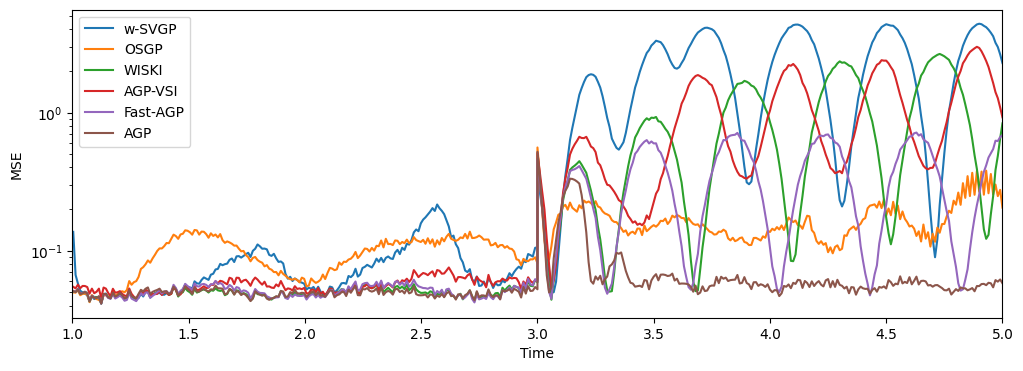

In [29]:
field = 'mse'

fig = plt.figure(figsize=(12,4))

plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_w_SVGP[field])),0), label='w-SVGP')

plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_OSGP[field])),0), label='OSGP')

plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_WISKI[field])),0), label='WISKI')

plt.semilogy(X_t,np.mean(np.squeeze(np.array(data_AGP_VSI[field])),0), label='AGP-VSI')

plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_fast_AGP[field])),0),label='Fast-AGP')

plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_AGP[field])),0), label='AGP')

plt.legend()

plt.xlabel("Time")
plt.ylabel("MSE")
plt.xlim(1.,5.)

fig.savefig('../results/figs/MSE_Comparative.png')

In [30]:
print('&  w-SVGP & OSGP & WISKI  & AGP-VSI &  Fast-AGP & AGP\\\\ \\hline  \\hline')
      
for field in ['mse', 'IC_95', 'train_time']:
    if field == 'mse':
            print('MSE & %2.4f & %2.4f & %2.4f & %2.4f & %2.4f & %2.4f  \\\\' %(np.mean(data_w_SVGP[field]), np.mean(data_OSGP[field]), np.mean(data_WISKI[field]), np.mean(data_AGP_VSI[field]), np.mean(data_fast_AGP[field]), np.mean(data_AGP[field])))
    if field == 'IC_95':
        print('IC 95 & %2.2f & %2.2f & %2.2f & %2.2f & %2.2f & %2.2f  \\\\' %(100*np.mean(data_w_SVGP[field]), 100*np.mean(data_OSGP[field]), 100*np.mean(data_WISKI[field]), 100*np.mean(data_AGP_VSI[field]), 100*np.mean(data_fast_AGP[field]), 100*np.mean(data_AGP[field])))
    if field == 'train_time':
        print('Tr. Time & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f  \\\\ \\hline' %(np.mean(data_w_SVGP[field]), np.mean(data_OSGP[field]), np.mean(data_WISKI[field]), np.mean(data_AGP_VSI[field]), np.mean(data_fast_AGP[field]), np.mean(data_AGP[field])))

&  w-SVGP & OSGP & WISKI  & AGP-VSI &  Fast-AGP & AGP\\ \hline  \hline
MSE & 1.0989 & 0.1333 & 0.4507 & 0.5211 & 0.1960 & 0.0630  \\
IC 95 & 93.10 & 94.21 & 75.28 & 93.71 & 71.68 & 95.02  \\
Tr. Time & 3266.2 & 299.5 & 120.4 & 3022.0 & 23.1 & 108.6  \\ \hline


## Results for different $\lambda$ values

In [31]:
with open('../results/Toy_AGP_lamb_3.pickle', 'rb') as handle:
    data_lamb_3 = pickle.load(handle)

with open('../results/Toy_AGP_lamb_2.pickle', 'rb') as handle:
    data_lamb_2 = pickle.load(handle)

with open('../results/Toy_AGP_lamb_1.pickle', 'rb') as handle:
    data_lamb_1 = pickle.load(handle)
    
with open('../results/Toy_AGP_lamb_0.75.pickle', 'rb') as handle:
    data_lamb_075 = pickle.load(handle)

with open('../results/Toy_AGP_lamb_0.5.pickle', 'rb') as handle:
    data_lamb_05 = pickle.load(handle)

with open('../results/Toy_AGP_lamb_0.25.pickle', 'rb') as handle:
    data_lamb_025 = pickle.load(handle)
    
with open('../results/Toy_AGP_lamb_0.pickle', 'rb') as handle:
    data_lamb_0 = pickle.load(handle)

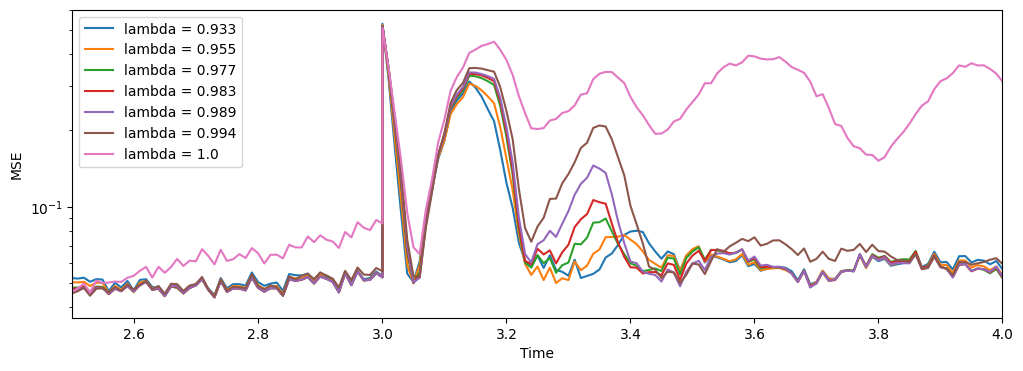

In [32]:
field = 'mse'

fig = plt.figure(figsize=(12,4))

lamb_ = np.round(np.exp(np.log(10**(-3))/T) ,3)
plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_lamb_3[field])),0), label='lambda = '+str(lamb_))

lamb_ = np.round(np.exp(np.log(10**(-2))/T),3)
plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_lamb_2[field])),0), label='lambda = '+str(lamb_))

lamb_ = np.round(np.exp(np.log(10**(-1))/T),3) 
plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_lamb_1[field])),0), label='lambda = '+str(lamb_))

lamb_ = np.round(np.exp(np.log(10**(-0.75))/T),3) 
plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_lamb_075[field])),0), label='lambda = '+str(lamb_))

lamb_ = np.round(np.exp(np.log(10**(-0.5))/T),3) 
plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_lamb_05[field])),0), label='lambda = '+str(lamb_))

lamb_ = np.round(np.exp(np.log(10**(-0.25))/T),3)
plt.semilogy(X_t, np.mean(np.squeeze(np.array(data_lamb_025[field])),0), label='lambda = '+str(lamb_))

lamb_ = np.exp(np.log(10**(-0))/T) 
plt.semilogy(X_t,np.mean(np.squeeze(np.array(data_lamb_0[field])),0), label='lambda = '+str(lamb_))


plt.legend()

plt.xlabel("Time")
plt.ylabel("MSE")
plt.xlim(2.5,4.)

fig.savefig('../results/figs/MSE_Comparative_lamb.png')